In [0]:
%cd /content/drive/Shared\ drives/CS230 
%cd google_action_recognition_trial

/content/drive/Shared drives/CS230
/content/drive/Shared drives/CS230/google_action_recognition_trial


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv3D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Reshape,AveragePooling3D, Bidirectional, LSTM, TimeDistributed, Lambda, Concatenate
from keras.models import Model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.utils import plot_model
from keras.initializers import VarianceScaling
from keras.backend import mean
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
import os

Using TensorFlow backend.


In [0]:
#helper fn for one hot label generation
def to_one_hot(labels):
  output = np.zeros(( np.size(labels),6 ))
  label_dict = {'backhand':0,'forehand':1, 'bvolley':2, 'fvolley':3, 'smash':4, 'service':5}
  for n in np.arange(np.size(labels)):
    label = labels[n]
    output[n, label_dict[label]] = 1
  return output 

In [0]:
#helper functions
import csv

def create_data(dataset='train',size=20):
  data = np.zeros([size,1,7,7,2046])
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:
        features = np.load('evanet/data/0/' + row[2] + '.npy' )
        data[i] = np.mean(features,axis=1,keepdims=True).reshape(1,7,7,2046)
        labels.append(row[1])
        print('Loading ' + row[0] + ' data ' + str(i))
        i+= 1

  with h5py.File(dataset+'.hdf5', 'w') as f:
    write_data = f.create_dataset('X', np.shape(data))
    write_data[:] = data 

def load_labels(dataset='train',size=20):
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:  
        labels.append(row[1])
        i+=1
  return to_one_hot(labels)

def load_data(size_whole,dataset='train'):
  with h5py.File(dataset+'.hdf5', 'r') as f:
    data = np.array(f['X'])
    size = data.shape[0]
  labels_one_hot = load_labels(dataset=dataset,size=size)

  return data[:size_whole], labels_one_hot[:size_whole]


def create_small_dataset(dataset='train',size=20):
  data = np.zeros([size,1,7,7,2046])
  labels = []
  with open('evanet/data/data_file_0.csv', 'r') as csvfile:
    full_set = csv.reader(csvfile, delimiter=',')
    i = 0
    for row in full_set:
      if row[0] == dataset and i < size:
        features = np.load('evanet/data/0/' + row[2] + '.npy' )
        data[i] = np.mean(features,axis=1,keepdims=True).reshape(1,7,7,2046)
        labels.append(row[1])
        print('Loading ' + row[0] + ' data ' + str(i))
        i+= 1
  return data, to_one_hot(labels)

In [0]:
#X_train_1, Y_train_1 = create_small_dataset(dataset='train', size=20)
X_train, Y_train = load_data(size_whole=1584,dataset='train')

In [0]:
X_val, Y_val = load_data(size_whole=204,dataset='validation')
X_test, Y_test = load_data(size_whole=192,dataset='test')

In [0]:
X_test.shape

(192, 1, 7, 7, 2046)

Deep Model

In [0]:
# Train network
dropout_rate=0.3
m=0.1
def model_instance(input_shape):
  X_input = Input(shape = input_shape)
  X = Conv3D(128,kernel_size=(1,7,7), padding='valid',kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal'))(X_input)
  #,kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal')  
  X = Reshape((128,))(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(128)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(64)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(32)(X)
  X = BatchNormalization(momentum=m)(X)
  X = Activation("relu")(X)
  X = Dropout(rate=dropout_rate)(X)
  X = Dense(6)(X)
  preds = Activation("softmax")(X)
  model = Model(inputs=X_input, outputs=preds)
  return model 

In [0]:
model = model_instance(input_shape=(1,7,7,2046))
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 1, 7, 7, 2046)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 1, 1, 1, 128)      12832640  
_________________________________________________________________
reshape_16 (Reshape)         (None, 128)               0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 128)               512       
_________________________________________________________________
activation_76 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 128)               165

In [0]:
if not os.path.exists('Checkpoints'):
    os.mkdir('Checkpoints')
opt=Adam()
checkpoint = ModelCheckpoint(os.path.join('Checkpoints','weights_model_0_dr03_m5_new.hdf5'), monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='auto')
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
model.fit(X_train, Y_train, epochs = 1000, batch_size=128,callbacks=[checkpoint],validation_data=(X_val,Y_val), shuffle=True, validation_freq=1)

Train on 1584 samples, validate on 204 samples
Epoch 1/1000
1584/1584 [==============================] - 4s 3ms/step - loss: 2.1285 - categorical_accuracy: 0.1515 - val_loss: 1.7521 - val_categorical_accuracy: 0.2451

Epoch 00001: val_categorical_accuracy improved from -inf to 0.24510, saving model to Checkpoints/weights_model_0_dr03_m5_new.hdf5
Epoch 2/1000
1584/1584 [==============================] - 1s 416us/step - loss: 1.9615 - categorical_accuracy: 0.1944 - val_loss: 1.7358 - val_categorical_accuracy: 0.2696

Epoch 00002: val_categorical_accuracy improved from 0.24510 to 0.26961, saving model to Checkpoints/weights_model_0_dr03_m5_new.hdf5
Epoch 3/1000
1584/1584 [==============================] - 1s 400us/step - loss: 1.8672 - categorical_accuracy: 0.2292 - val_loss: 1.6968 - val_categorical_accuracy: 0.2892

Epoch 00003: val_categorical_accuracy improved from 0.26961 to 0.28922, saving model to Checkpoints/weights_model_0_dr03_m5_new.hdf5
Epoch 4/1000
1584/1584 [================

In [0]:
opt=Adam(lr=0.01)
model.load_weights(os.path.join('Checkpoints','weights_model_0_dr03_m1_new.hdf5'))
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [0]:
print(model.evaluate(X_train,Y_train))
print(model.evaluate(X_val,Y_val))
print(model.evaluate(X_test,Y_test))

1584/1584 [==============================] - 2s 1ms/step
[0.07040292244743217, 0.9728535353535354]
204/204 [==============================] - 0s 270us/step
[0.8921865715700037, 0.7843137254901961]
192/192 [==============================] - 0s 264us/step
[0.88374362885952, 0.7760416666666666]


In [0]:
Y_probs=model.predict(X_test)

In [0]:
Y_pred=np.argmax(Y_probs,axis=1)

In [0]:
Y_test_cat=np.argmax(Y_test,axis=1) #categorical data of Y_test

In [0]:
target_names = ['backhand', 'forehand', 'bvolley', 'fvolley', 
                   'smash', 'service']

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print (classification_report(Y_test_cat, Y_pred, target_names=target_names))
conf_matrix = confusion_matrix(Y_test_cat, Y_pred)

              precision    recall  f1-score   support

    backhand       0.84      0.85      0.85        48
    forehand       0.79      0.77      0.78        48
     bvolley       0.80      0.75      0.77        16
     fvolley       0.83      0.62      0.71        16
       smash       0.60      0.56      0.58        16
     service       0.74      0.83      0.78        48

    accuracy                           0.78       192
   macro avg       0.77      0.73      0.75       192
weighted avg       0.78      0.78      0.77       192



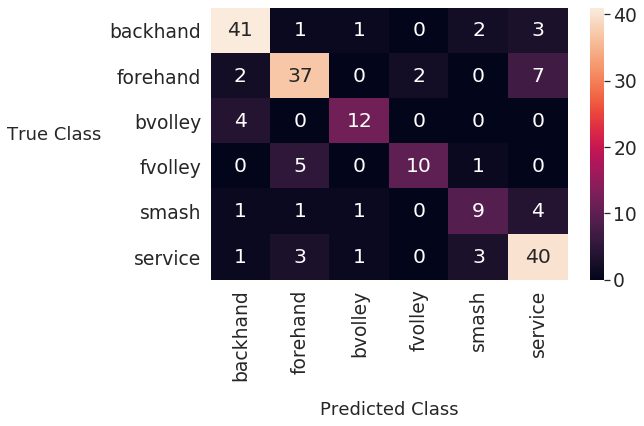

In [0]:
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.7)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (8,5))
ax = sns.heatmap(df_cm, annot=True)
ax.set_xlabel('Predicted Class', fontsize=18, labelpad=20)
ax.set_ylabel('True Class', fontsize=18, rotation=0, labelpad=55)
plt.savefig('confusion_matrix_shallow_0.jpg', bbox_inches = 'tight')
plt.show()